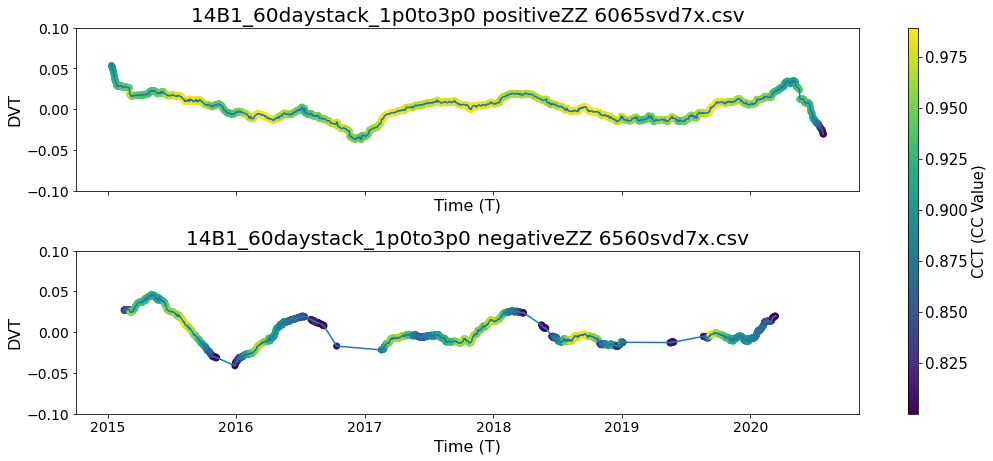

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# List of all file paths
file_paths = [
    '14B1_60daystack_1p0to3p0 positiveZZ 6065svd7x.csv',
    '14B1_60daystack_1p0to3p0 negativeZZ 6560svd7x.csv'
]

# Predefined array of inversion switches
inversion_array = [-1, -1, -1, -1, 1, -1]

start_date = pd.to_datetime("2015-01-01")
end_date = pd.to_datetime("2021-01-01")

# Create a figure with 6 subplots (3 rows and 2 columns)
fig, axs = plt.subplots(len(file_paths), 1, figsize=(15, len(file_paths)*3.33), sharex=True, sharey=False)

# Flatten the array of axes for easier iteration
axs = axs.flatten()

for idx, file_path in enumerate(file_paths):
    # Load the data
    data = pd.read_csv(file_path)
    
    # Convert the 'T' column to datetime format if necessary
    data['T'] = pd.to_datetime(data['T'])
    
    # Apply inversion based on the predefined array
    data['DVT'] *= inversion_array[idx]
    
    # Plotting scatter and line on the corresponding subplot
    scatter = axs[idx].scatter(data['T'], data['DVT'], c=data['CCT'], cmap='viridis', label='Scatter')
    axs[idx].plot(data['T'], data['DVT'], label='Line')
    
    # Set title and labels for each subplot
    axs[idx].set_title(os.path.basename(file_path), fontsize=20)
    axs[idx].set_xlabel('Time (T)', fontsize=16)
    axs[idx].set_ylabel('DVT', fontsize=16)
    axs[idx].tick_params(axis='both', which='major', labelsize=14)
    #axs[idx].set_xlim([start_date, end_date])  # Set x-axis limits
    axs[idx].set_ylim([-0.1, 0.1])  # Set x-axis limits

# Adjust subplot layout
plt.tight_layout()
#plt.ylim([-1.0,1.0])

# Add a color bar in the figure
fig.colorbar(scatter, ax=axs, orientation='vertical', label='CCT (CC Value)', aspect=40)

# Show the plot
plt.show()


In [208]:
weighted_dvv_df.index

DatetimeIndex(['2014-12-17', '2014-12-18', '2014-12-19', '2014-12-20',
               '2014-12-21', '2014-12-22', '2014-12-23', '2014-12-24',
               '2014-12-25', '2014-12-26',
               ...
               '2020-07-23', '2020-07-24', '2020-07-25', '2020-07-26',
               '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30',
               '2020-07-31', '2020-08-01'],
              dtype='datetime64[ns]', length=2055, freq=None)

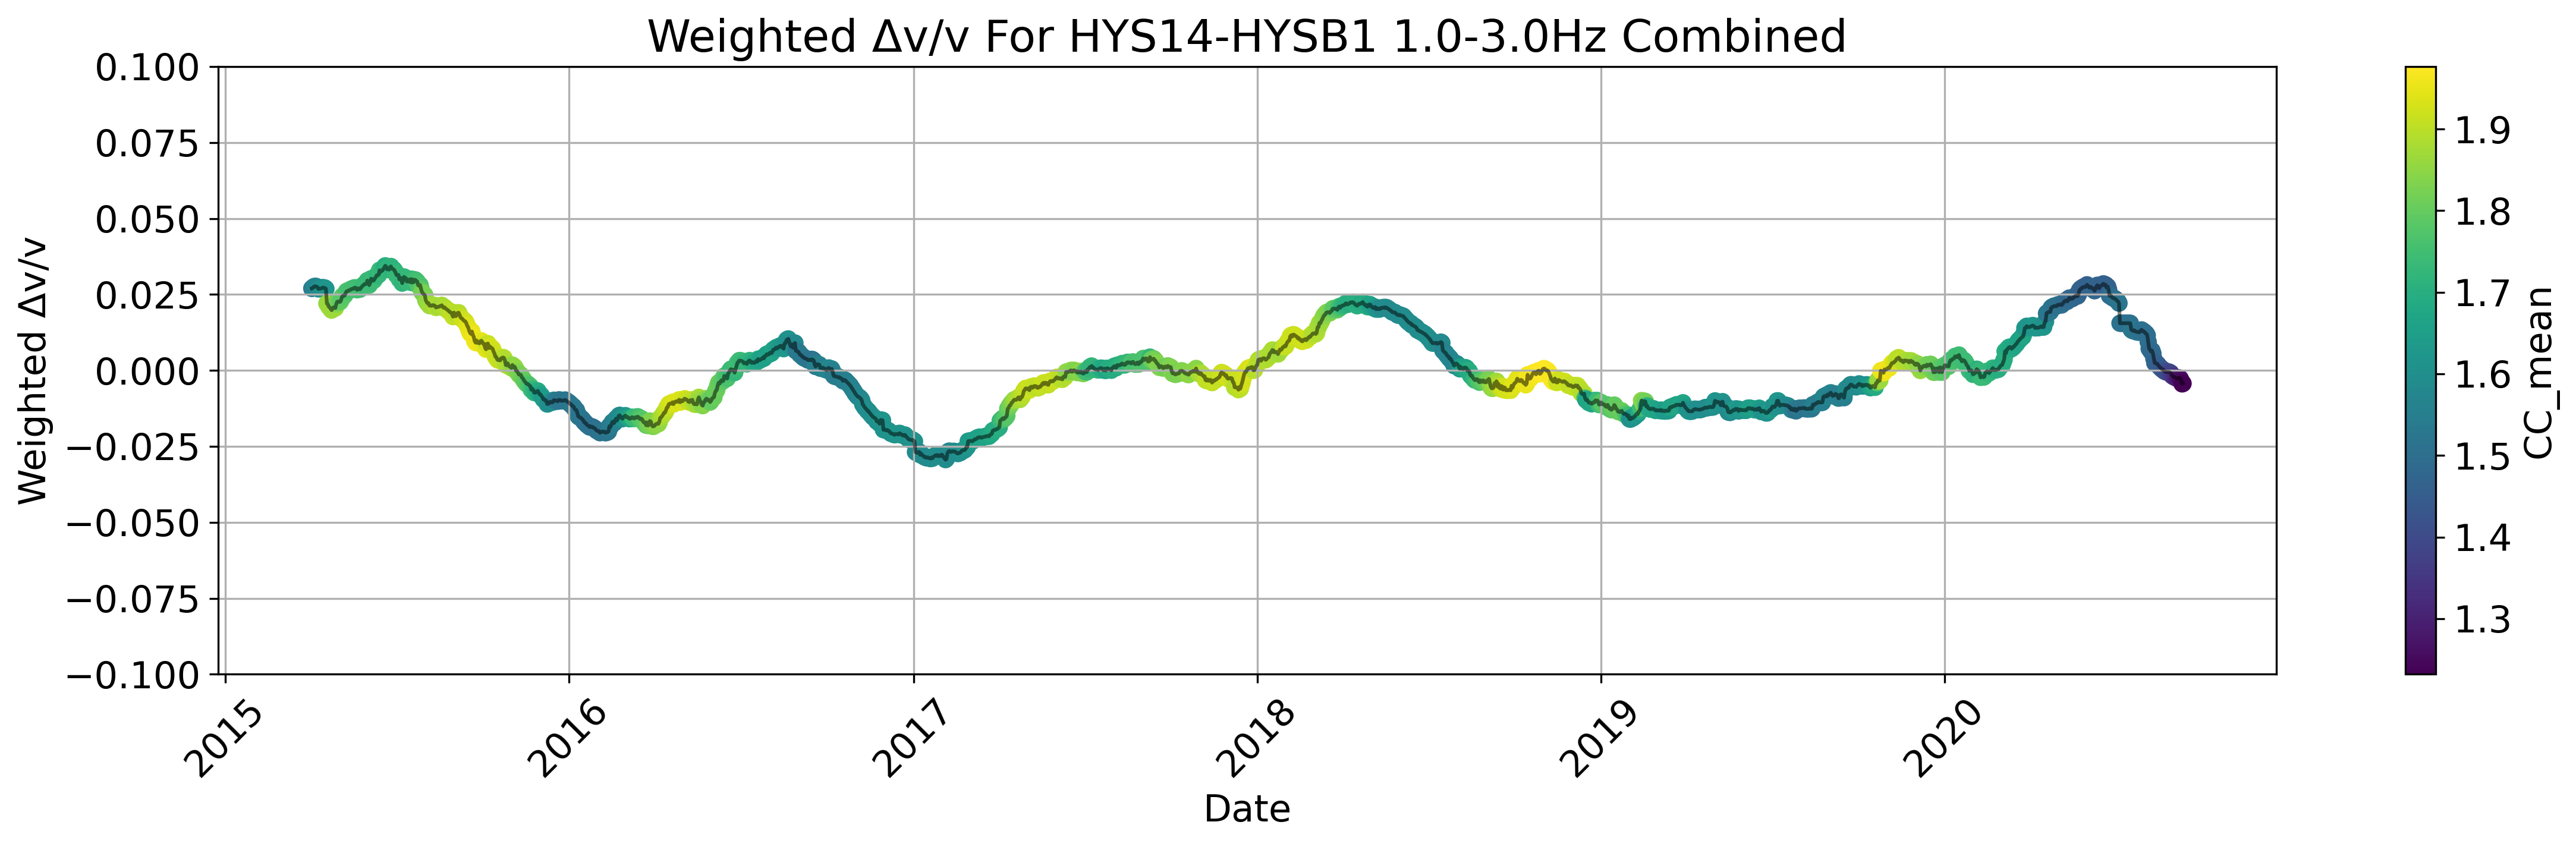

In [224]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm


# Define the paths to your CSV files
file_paths = [
    '14B1_60daystack_1p0to3p0 positiveZZ 6065svd7x.csv',
    '14B1_60daystack_1p0to3p0 negativeZZ 6560svd7x.csv'
]

# Predefined array with multipliers (-1 or +1)
multipliers = [-1, -1, -1, -1, 1, -1]

dataframes = []
for path, multiplier in zip(file_paths, multipliers):
    df = pd.read_csv(path)
    df['DVT'] *= multiplier  # Apply the multiplier to the DVT column
    dataframes.append(df)

# Parse timestamps and set them as the index
for df in dataframes:
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)
    
    

# Create a unified time index from the union of all timestamps in the dataframes
unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

# Interpolate data for each dataframe to match the unified index
interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

# Define the date range to exclude
start_date = pd.to_datetime("2010-01-01")
end_date = pd.to_datetime("2015-01-15")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
start_date = pd.to_datetime("2020-08-01")
end_date = pd.to_datetime("2021-01-15")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
# Calculate CC_mean using squared correlation coefficients for each time point
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)

# Calculate weighted Δu/u using squared CCT and DVT
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Normalize CC_mean for coloring
norm = mcolors.Normalize(vmin=CC_mean.min(), vmax=CC_mean.max())
cmap = cm.viridis  # Can choose any available colormap

# Create a DataFrame for the weighted Δv/v time series
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

weighted_dvv_df.index = weighted_dvv_df.index + pd.DateOffset(days=45)

# Plotting the weighted Δv/v time series with color-coded CC_mean
plt.figure(figsize=(16, 5), dpi=300)
# Scatter plot for individual markers with color coding
sc = plt.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cmap, norm=norm, label='Weighted Δv/v')
# Line plot to connect markers
plt.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)  # Adjust alpha for line transparency
plt.colorbar(sc, label='CC_mean')
# Adding a trend line
z = np.polyfit(weighted_dvv_df.index.astype(np.int64), weighted_dvv_df['Weighted Δv/v'], 1)
p = np.poly1d(z)
plt.plot(weighted_dvv_df.index, p(weighted_dvv_df.index.astype(np.int64)), "r--", label='Trend Line')
plt.title('Weighted Δv/v For HYS14-HYSB1 1.0-3.0Hz Combined')
plt.xlabel('Date')
plt.ylim([-0.1,0.1])
plt.ylabel('Weighted Δv/v')
plt.grid(True)
plt.rcParams.update({'font.size': 15})  # Increase font size
#start_date = pd.to_datetime("2010-07-01")
#end_date = pd.to_datetime("2024-03-01")

#plt.xlim([start_date, end_date])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# Define the date range to exclude
start_date = pd.to_datetime("2017-03-25")
end_date = pd.to_datetime("2017-06-02")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
start_date = pd.to_datetime("2016-10-30")
end_date = pd.to_datetime("2016-12-03")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)

2060

In [ ]:
# Define the date range to exclude
start_date = pd.to_datetime("2010-01-01")
end_date = pd.to_datetime("2014-12-01")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
start_date = pd.to_datetime("2016-10-31")
end_date = pd.to_datetime("2016-10-02")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    


In [ ]:
# Define the date range to exclude
start_date = pd.to_datetime("2010-01-01")
end_date = pd.to_datetime("2014-12-01")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
start_date = pd.to_datetime("2016-09-29")
end_date = pd.to_datetime("2016-11-20")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    

In [ ]:
# Define the date range to exclude
start_date = pd.to_datetime("2010-01-01")
end_date = pd.to_datetime("2014-12-01")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
start_date = pd.to_datetime("2016-10-15")
end_date = pd.to_datetime("2016-12-30")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
start_date = pd.to_datetime("2017-04-10")
end_date = pd.to_datetime("2017-06-03")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    


## Weighted Δv/v For HYS14 0.1-0.3Hz Combined

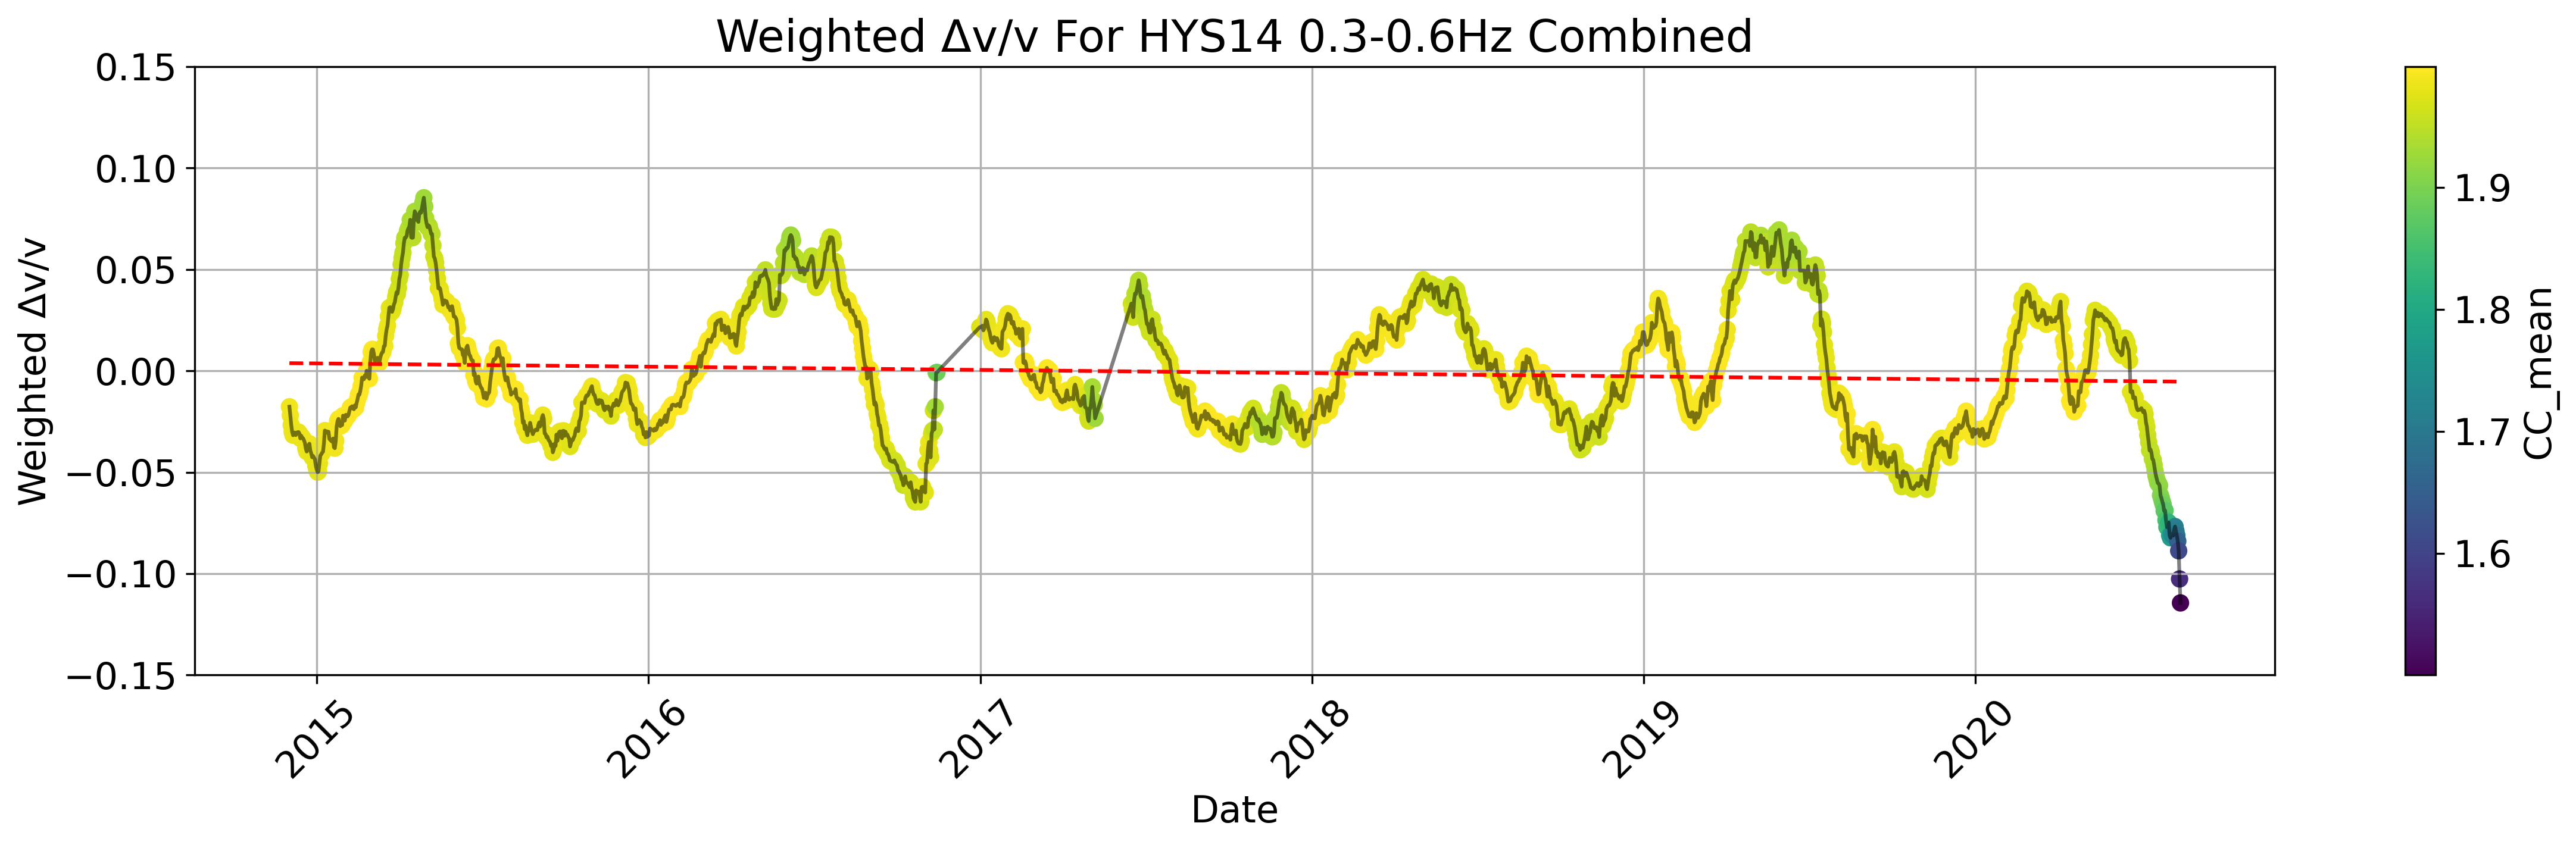

In [172]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm


# Define the paths to your CSV files
file_paths = [
    '14_60daystack_0p3to0p6 positiveZE 2060svd7x.csv',
    '14_60daystack_0p3to0p6 negativeZE 6020svd7x.csv',
]

# Predefined array with multipliers (-1 or +1)
multipliers = [1, -1, -1, 1, 1, 1]

dataframes = []
for path, multiplier in zip(file_paths, multipliers):
    df = pd.read_csv(path)
    df['DVT'] *= multiplier  # Apply the multiplier to the DVT column
    dataframes.append(df)

# Parse timestamps and set them as the index
for df in dataframes:
    df['T'] = pd.to_datetime(df['T'])
    df.set_index('T', inplace=True)
    
    

# Create a unified time index from the union of all timestamps in the dataframes
unified_index = pd.to_datetime(sorted(set.union(*(set(df.index) for df in dataframes))))

# Interpolate data for each dataframe to match the unified index
interpolated_dfs = [df.reindex(unified_index).interpolate() for df in dataframes]

# Define the date range to exclude
start_date = pd.to_datetime("2010-01-01")
end_date = pd.to_datetime("2014-12-01")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
start_date = pd.to_datetime("2016-11-15")
end_date = pd.to_datetime("2016-12-30")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    
start_date = pd.to_datetime("2017-05-08")
end_date = pd.to_datetime("2017-06-15")

# Exclude the specified date range
for i in range(len(interpolated_dfs)):
    interpolated_dfs[i] = interpolated_dfs[i].drop(interpolated_dfs[i].loc[start_date:end_date].index)
    

# Calculate CC_mean using squared correlation coefficients for each time point
CC_mean = sum(df['CCT']**2 for df in interpolated_dfs)

# Calculate weighted Δu/u using squared CCT and DVT
weighted_dvv = sum(df['CCT']**2 * df['DVT'] for df in interpolated_dfs) / CC_mean

# Normalize CC_mean for coloring
norm = mcolors.Normalize(vmin=CC_mean.min(), vmax=CC_mean.max())
cmap = cm.viridis  # Can choose any available colormap

# Create a DataFrame for the weighted Δv/v time series
weighted_dvv_df = pd.DataFrame(weighted_dvv, columns=['Weighted Δv/v'])

# Plotting the weighted Δv/v time series with color-coded CC_mean
plt.figure(figsize=(16, 5), dpi=300)
# Scatter plot for individual markers with color coding
sc = plt.scatter(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], c=CC_mean, cmap=cmap, norm=norm, label='Weighted Δv/v')
# Line plot to connect markers
plt.plot(weighted_dvv_df.index, weighted_dvv_df['Weighted Δv/v'], 'k-', alpha=0.5)  # Adjust alpha for line transparency
plt.colorbar(sc, label='CC_mean')
# Adding a trend line
z = np.polyfit(weighted_dvv_df.index.astype(np.int64), weighted_dvv_df['Weighted Δv/v'], 1)
p = np.poly1d(z)
plt.plot(weighted_dvv_df.index, p(weighted_dvv_df.index.astype(np.int64)), "r--", label='Trend Line')
plt.title('Weighted Δv/v For HYS14 0.3-0.6Hz Combined')
plt.xlabel('Date')
plt.ylim([-0.15,0.15])
plt.ylabel('Weighted Δv/v')
plt.grid(True)
plt.rcParams.update({'font.size': 15})  # Increase font size
#start_date = pd.to_datetime("2010-07-01")
#end_date = pd.to_datetime("2024-03-01")

#plt.xlim([start_date, end_date])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()